# DeepMeta : Run inference
This is an example to show how to run prediction with DeepMeta.


In [54]:
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure as measure

import DeepMeta.predict as p
import DeepMeta.utils.data as data
import DeepMeta.utils.global_vars as gv

%matplotlib inline

## Load data
First we need to load a mouse:

In [55]:
img_path = os.path.join(gv.PATH_DATA, "Souris_Test/PL_ssiso_1.tif")
mouse = data.get_predict_dataset(img_path, contrast=False)

Once your mouse loaded, verify its shape and look at it.

In [56]:
print(np.shape(mouse))

(128, 128, 128, 1)


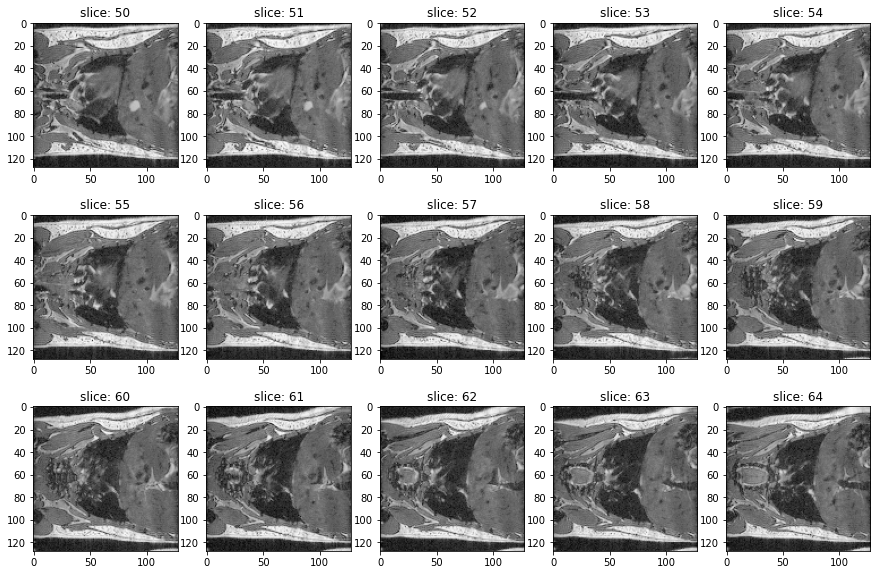

In [57]:
fig = plt.figure(figsize=(15,10))
columns = 5
rows = 3

# ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows):
    img = mouse[50+i]
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title("slice: "+str(50+i))
    plt.imshow(img, cmap="gray")
plt.show()

## Segment lungs
Once you are satisfied of your input, choose a trained model to do inference :

In [58]:
path_model_lungs = "../data/saved_models/Poumons/best_seg_model_weighted.h5"
seg_lungs = p.predict_seg(mouse, path_model_lungs).reshape(128, 128, 128)

Here `seg_lungs` is the raw output from the network.
We can look at it:

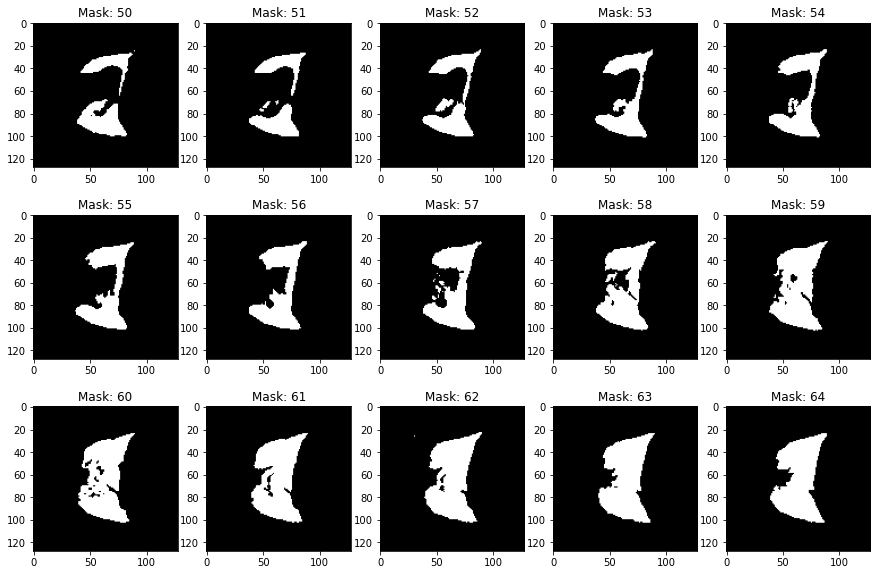

In [59]:
def plot_images(img_list, prefix, start):
    fig = plt.figure(figsize=(15,10))
    columns = 5
    rows = 3
    ax = []
    for i in range(columns*rows):
        img = img_list[start+i]
        ax.append( fig.add_subplot(rows, columns, i+1) )
        ax[-1].set_title(prefix+str(start+i))
        plt.imshow(img, cmap="gray")
    plt.show()

plot_images(seg_lungs, "Mask: ", 50)

This result is not so bad, but we can improve it with a post processing pipeline:

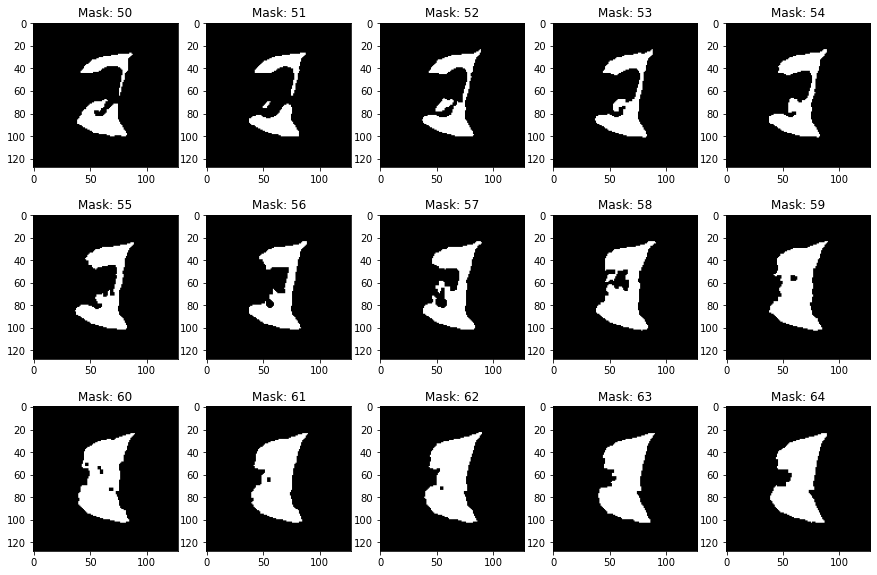

In [60]:
seg_lungs = p.postprocess_loop(seg_lungs)
plot_images(seg_lungs, "Mask: ", 50)

Our masks are better, but we do not see if they fit perfectly on our images.
To have a better view, we will draw the masks borders on the mouse images.

In [78]:
def draw_border(dataset, masks):
    fig = plt.figure(figsize=(15,10))
    ax = []
    for i, img in enumerate(dataset[50:65]):
        mask = masks[50+i]
        cell_contours = measure.find_contours(mask, 0.8)
        ax.append(fig.add_subplot(3, 5, i+1))
        for contour in cell_contours:
            plt.plot(contour[:, 1], contour[:, 0], linewidth=1, color="red")
        plt.imshow(img, cmap="gray")
        ax[-1].set_title("Slice : "+str(50+i))
    plt.show()

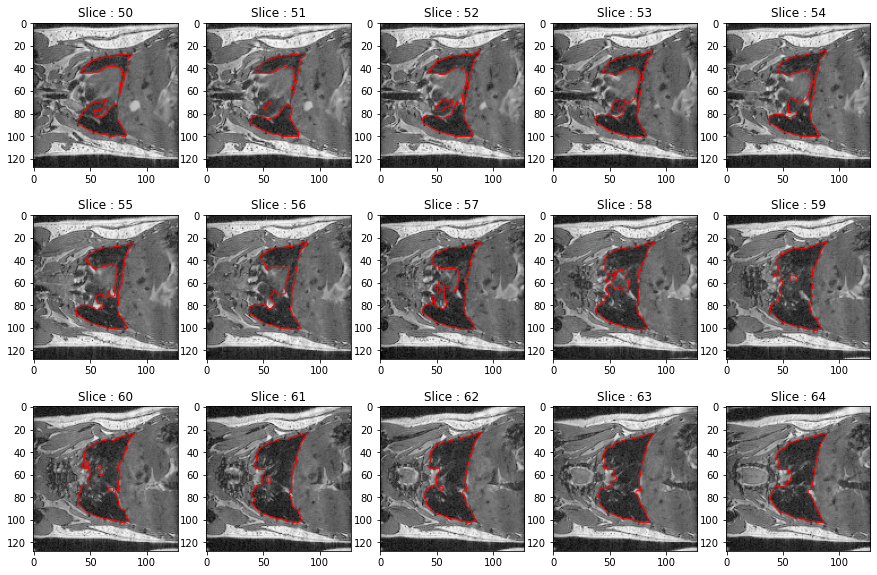

In [79]:
draw_border(mouse, seg_lungs)

## Segment metastasis
Now we can segment metastasis

In [62]:
path_model_seg_metas = "../data/saved_models/Metastases/best_seg_weighted.h5"
seg_metas = seg_lungs * p.predict_seg(mouse, path_model_seg_metas).reshape(128, 128, 128)

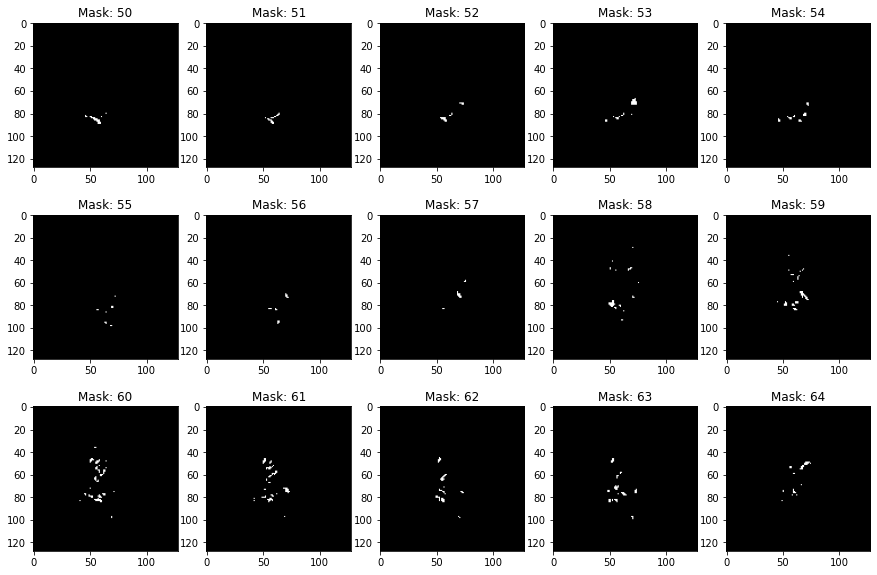

In [63]:
plot_images(seg_metas, "Mask: ", 50)

Like previously, we can enhance our result with a post-processing pipeline.

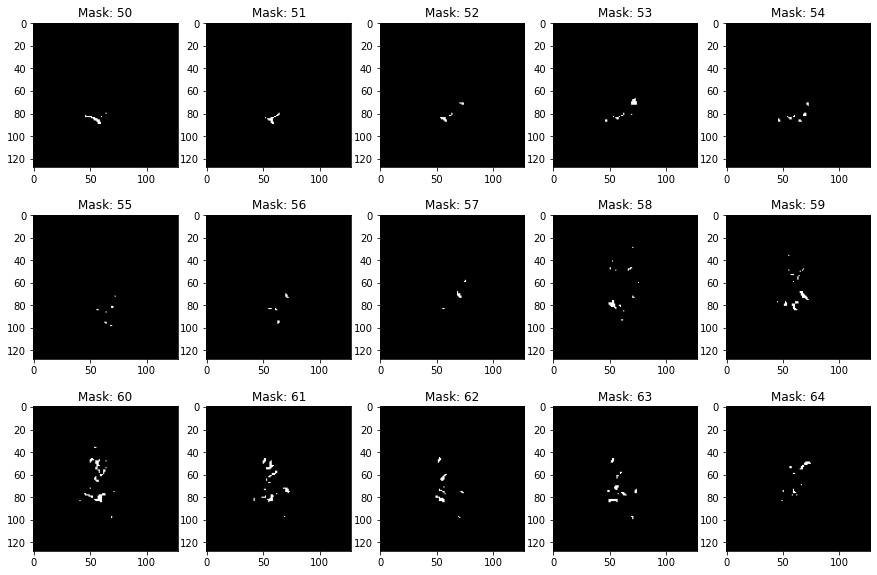

In [64]:
seg_metas = p.postprocess_meta(seg_metas, k1=3, k2=3)
plot_images(seg_metas, "Mask: ", 50)

We can now draw our masks borders on our images.

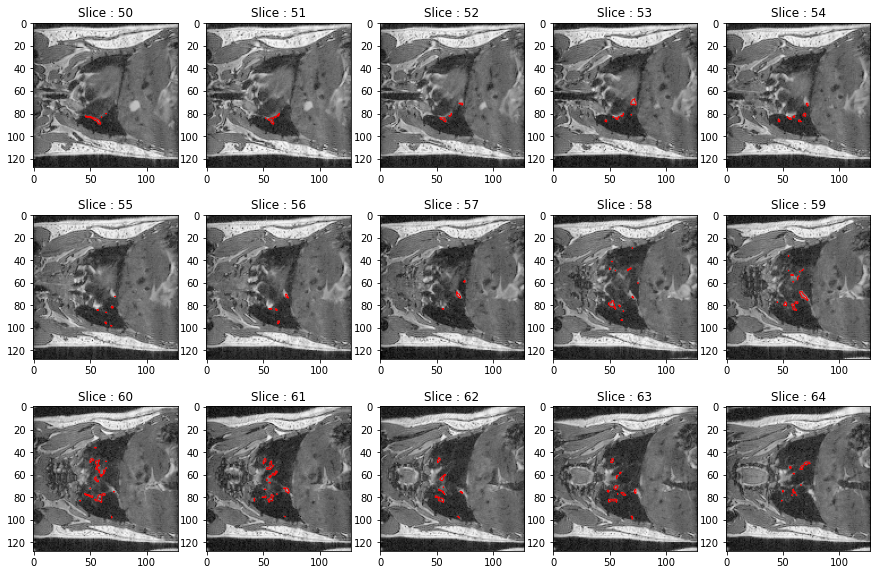

In [80]:
draw_border(mouse, seg_metas)